In [2]:
import pandas as pd
import numpy as np
import pingouin as pg
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op

In [3]:
ANNOT_DIR = Path("derivatives/annotations")
OUT_DIR = Path("derivatives/caps/interrater")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
annot_df = pd.read_csv(op.join(ANNOT_DIR, "S01E01R01.csv"))  
episode_df = pd.read_csv(op.join(ANNOT_DIR, "S01E01.csv"))

In [37]:
annot_df.head()

,index,valence_1,valence_2,arousal_1,arousal_2
0,S01E01R01_clip0000,5,5,3,1
1,S01E01R01_clip0001,5,5,3,1
2,S01E01R01_clip0002,5,5,3,1
3,S01E01R01_clip0003,5,5,3,1
4,S01E01R01_clip0004,5,5,3,1


In [38]:
# Collect columns with 'valence' in their names
valence_cols = [col for col in annot_df.columns if 'valence' in col.lower()]
print("Valence columns found:")
print(valence_cols)
print(f"\nNumber of valence columns: {len(valence_cols)}")

# Display the valence data
print("\nValence data preview:")
annot_df[valence_cols].head()

Valence columns found:
['valence_1', 'valence_2']

Number of valence columns: 2

Valence data preview:


,valence_1,valence_2
0,5,5
1,5,5
2,5,5
3,5,5
4,5,5


In [39]:
# Collect columns with 'valence' in their names
arousal_cols = [col for col in annot_df.columns if 'arousal' in col.lower()]
print("Arousal columns found:")
print(arousal_cols)
print(f"\nNumber of arousal columns: {len(arousal_cols)}")

# Display the arousal data
print("\nArousal data preview:")
annot_df[arousal_cols].head()

Arousal columns found:
['arousal_1', 'arousal_2']

Number of arousal columns: 2

Arousal data preview:


,arousal_1,arousal_2
0,3,1
1,3,1
2,3,1
3,3,1
4,3,1


In [43]:
# Calculate ICC between valence_1 and valence_2
if len(valence_cols) >= 2:
    # Prepare data for ICC calculation
    valence_data = annot_df[valence_cols[:2]].copy()  # Take first 2 valence columns
    
    # Convert to numeric and remove any missing values
    valence_data = valence_data.apply(pd.to_numeric, errors='coerce').dropna()
    
    print(f"Calculating ICC between {valence_cols[0]} and {valence_cols[1]}")
    print(f"Valid data points: {len(valence_data)}")
    print(valence_data.var())

    
    # Reshape data for ICC calculation (long format)
    # valence_long = valence_data.reset_index().melt(
    #     id_vars='index', 
    #     var_name='rater', 
    #     value_name='valence'
    # )
    
    # # Calculate ICC(2,1) - Two-way random effects, absolute agreement, single measurement
    # icc_result = pg.intraclass_corr(
    #     data=valence_long, 
    #     targets='index', 
    #     raters='rater', 
    #     ratings='valence'
    # )
    
    # print(icc_result)

Calculating ICC between valence_1 and valence_2
Valid data points: 334
valence_1    0.000000
valence_2    1.205121
dtype: float64


In [5]:
episode_df.head()

,run,index,valence_1,valence_2,arousal_1,arousal_2
0,S01E01R01,S01E01R01_clip0000,5,5,3,1
1,S01E01R01,S01E01R01_clip0001,5,5,3,1
2,S01E01R01,S01E01R01_clip0002,5,5,3,1
3,S01E01R01,S01E01R01_clip0003,5,5,3,1
4,S01E01R01,S01E01R01_clip0004,5,5,3,1



Processing S01E01


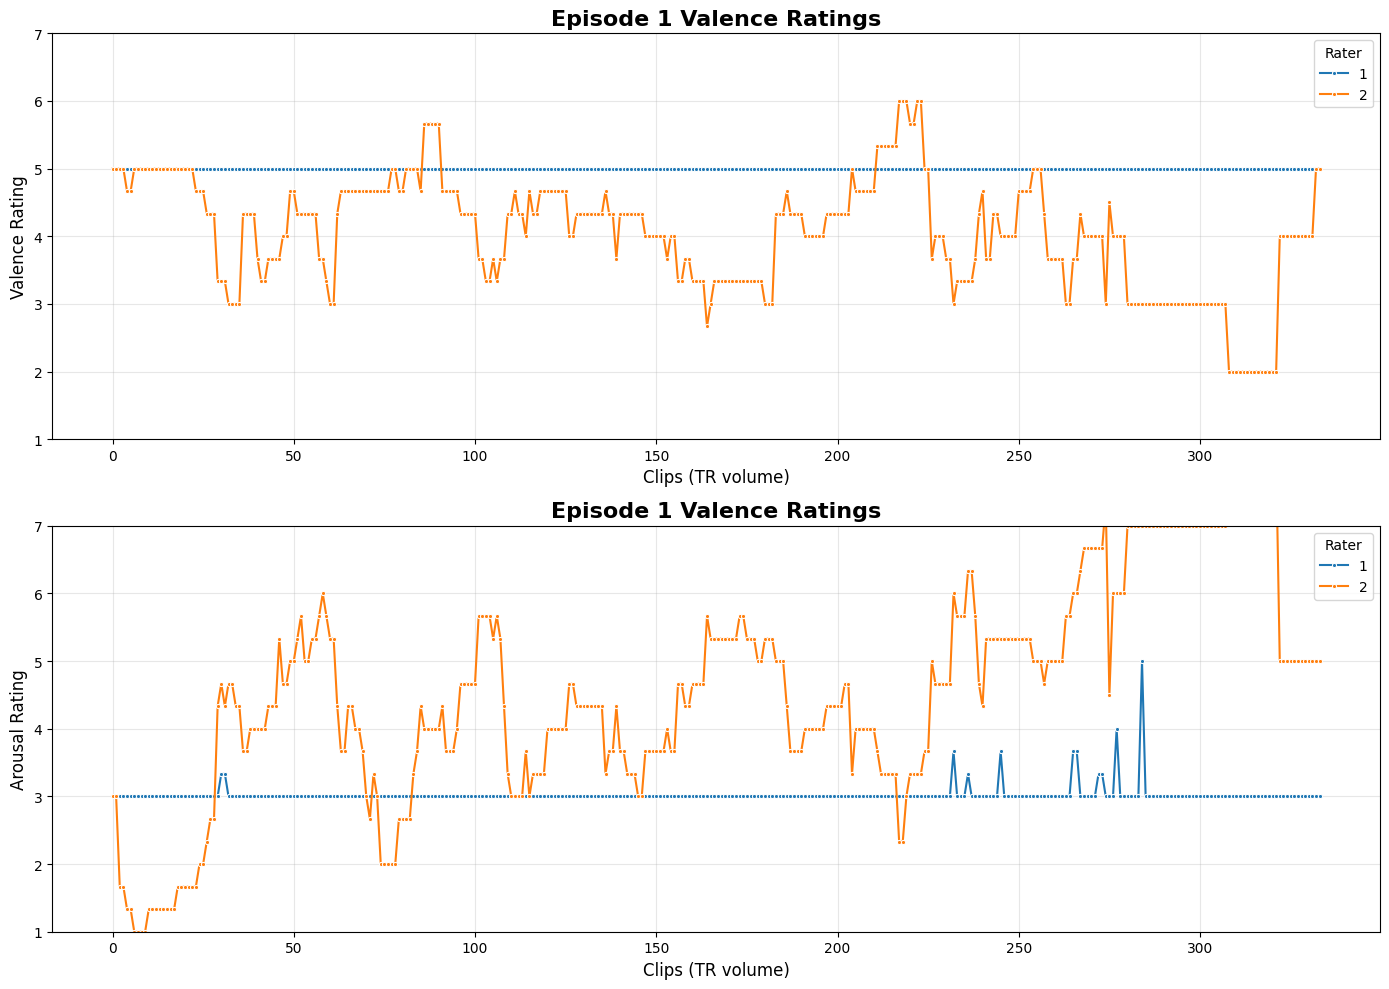

Index range: 0 - 333
Total data points: 885

Processing S01E02


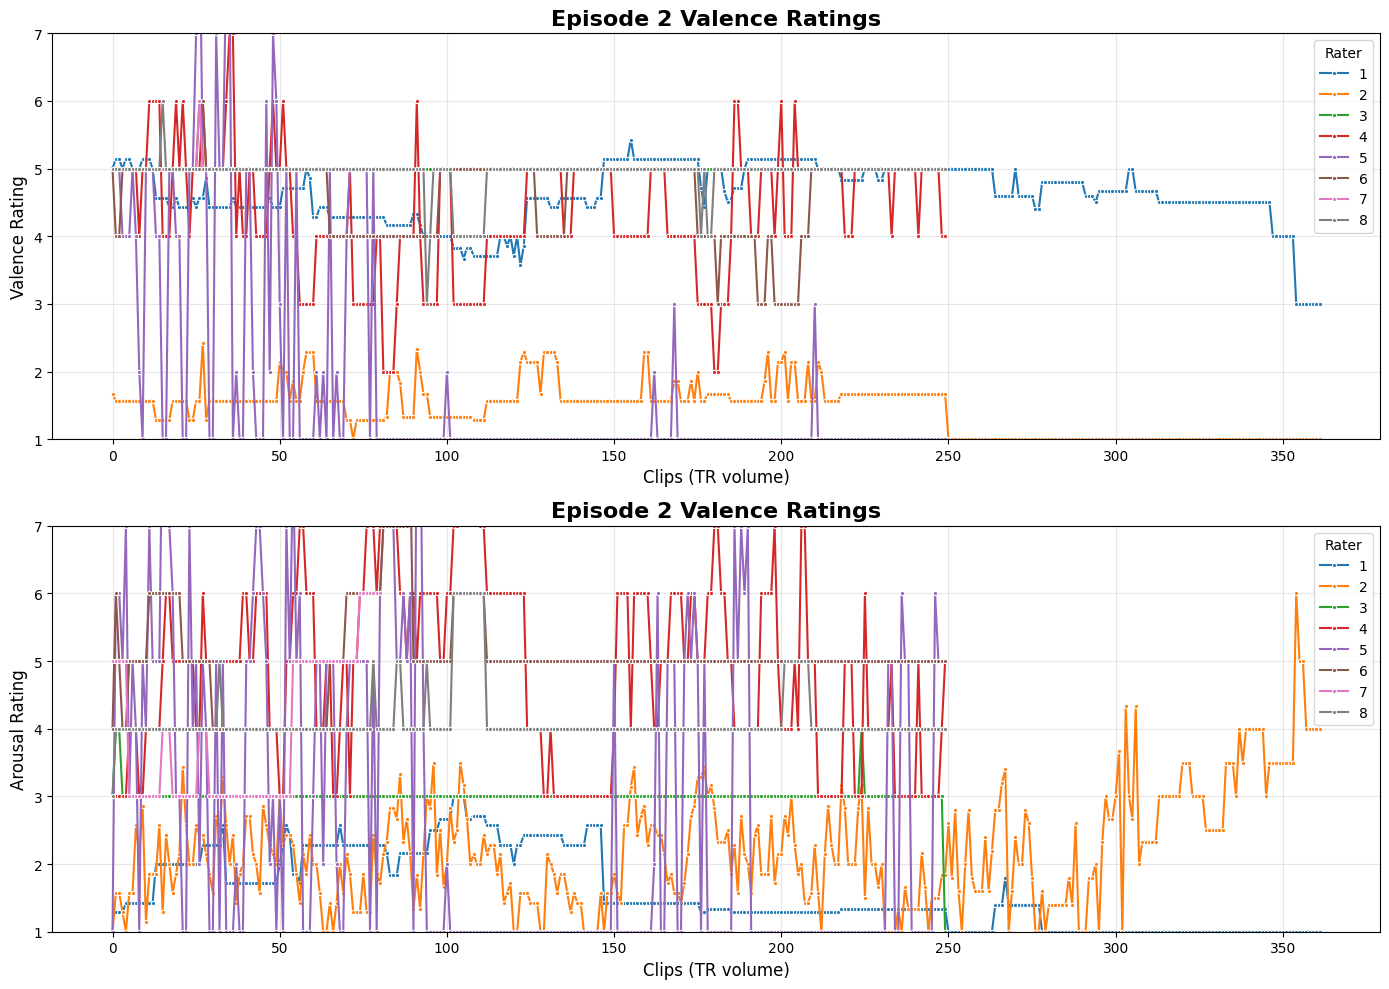

Index range: 0 - 361
Total data points: 2052

Processing S01E03


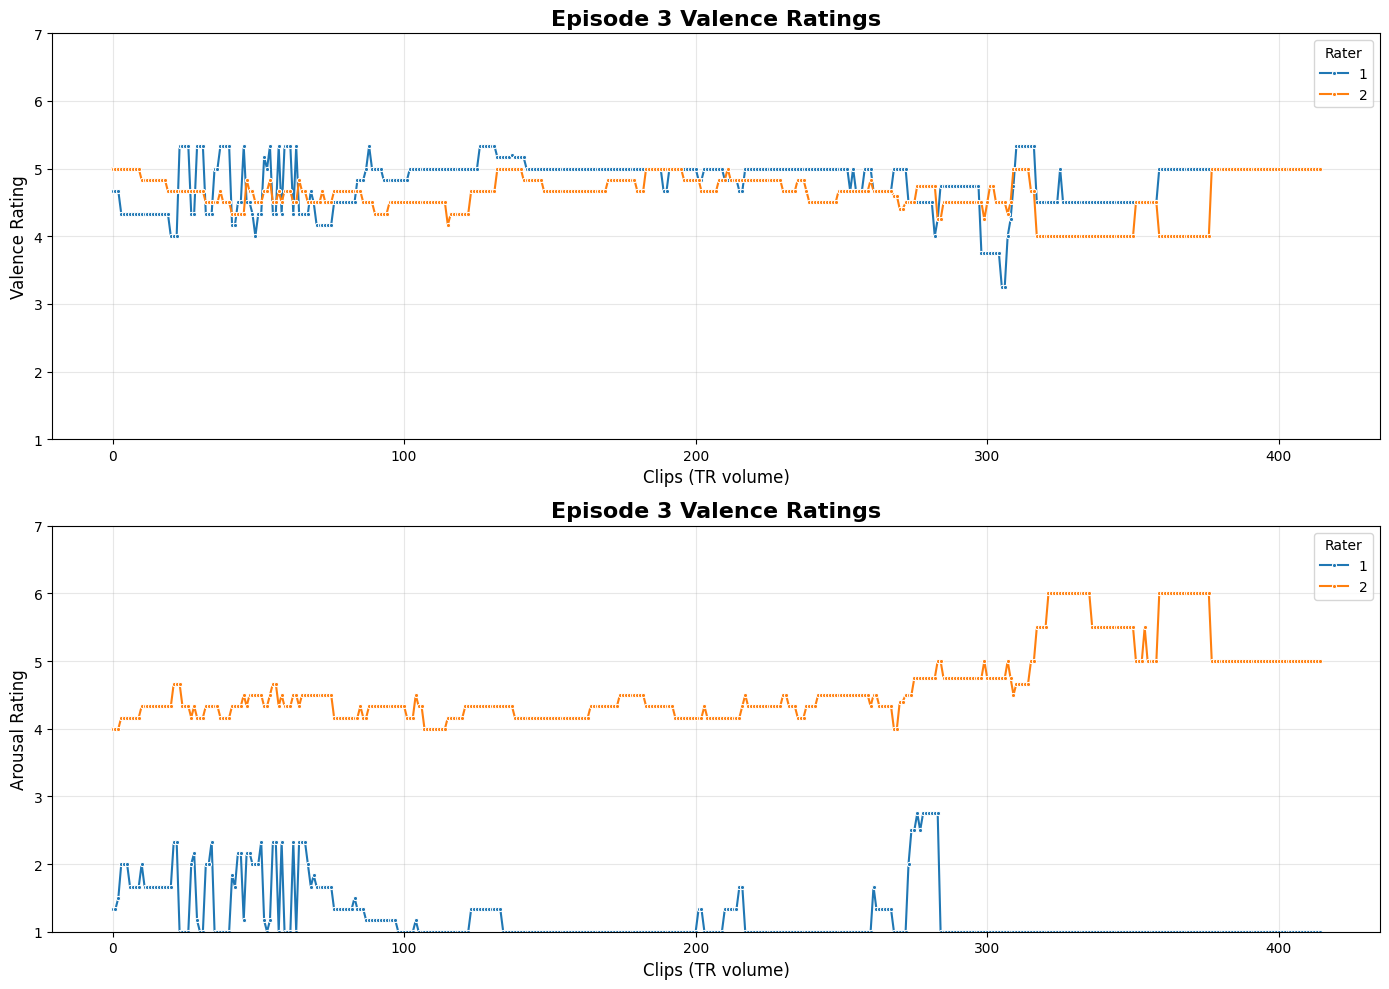

Index range: 0 - 414
Total data points: 1940

Processing S01E04


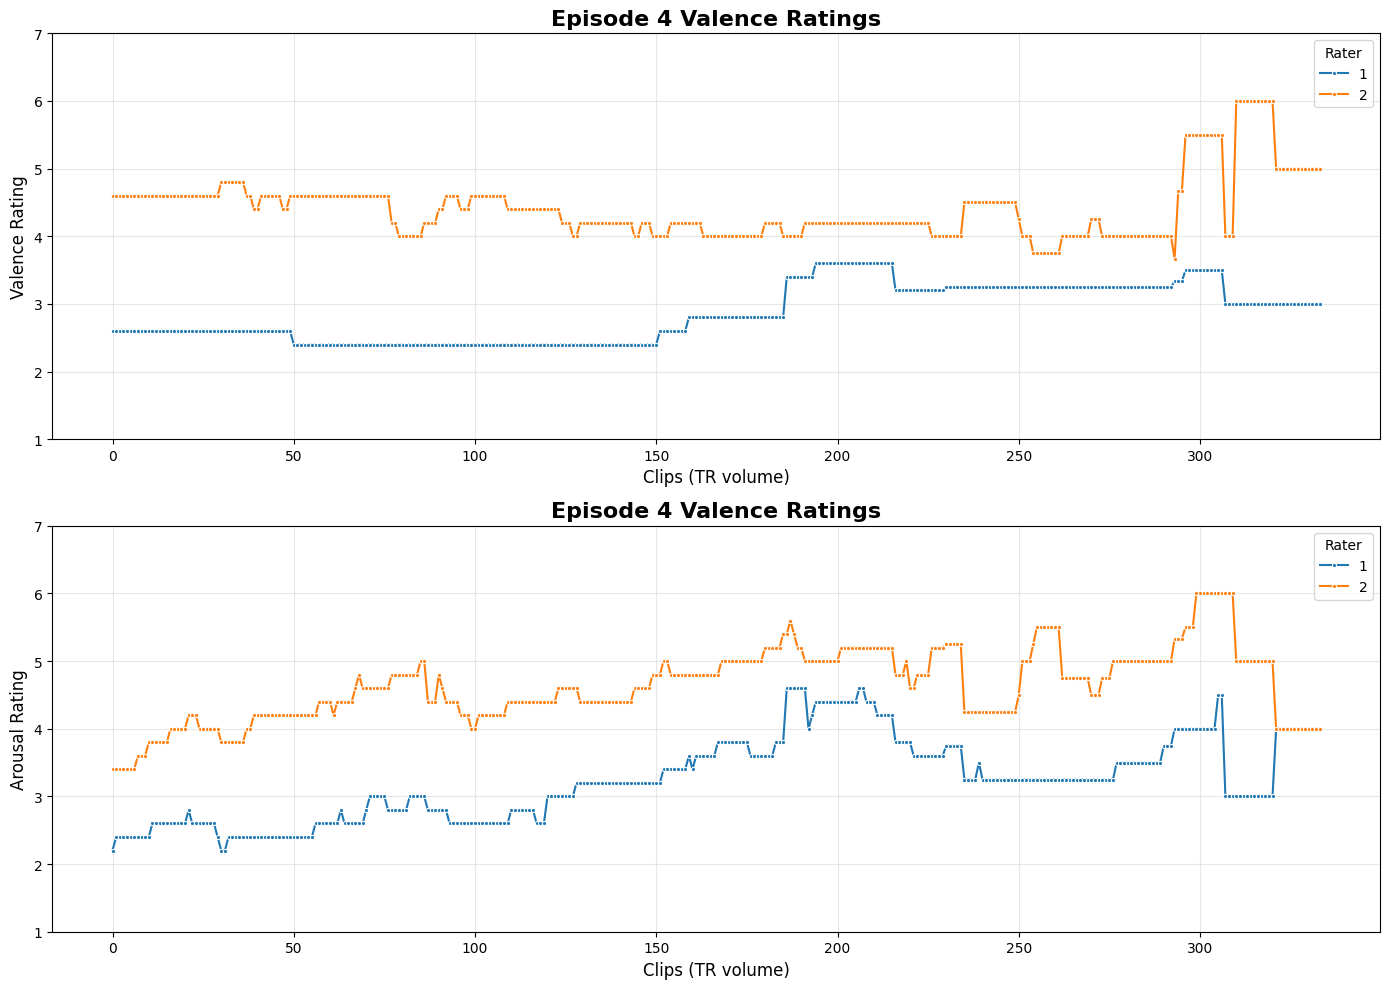

Index range: 0 - 333
Total data points: 1460

All episode plots completed!


In [24]:

# Find all episode CSV files
episode_numbers = [1,2,3,4]


for ep_num in episode_numbers:
    episode_file = ANNOT_DIR / f"S01E{ep_num:02d}.csv"
    # Extract episode name from filename
    episode_name = Path(episode_file).stem  # Gets filename without extension
    print(f"\n{'='*60}")
    print(f"Processing {episode_name}")
    print(f"{'='*60}")
    
    # Load episode data
    episode_df = pd.read_csv(episode_file)
    
    # Extract last 4 digits of index
    episode_df['index_short'] = episode_df['index'].astype(str).str[-4:].astype(int)
    
    # Get valence and arousal columns (only individual rater columns, no averages)
    val_cols = [col for col in episode_df.columns if 'valence' in col.lower()]
    aro_cols = [col for col in episode_df.columns if 'arousal' in col.lower()]

    
    # Prepare data for seaborn (long format)
    plot_data = []
    for col in val_cols:
        # Extract just the number from column name (e.g., valence_1 -> 1)
        rater_num = col.split('_')[-1] if '_' in col else col
        for idx, row in episode_df.iterrows():
            plot_data.append({
                'index_short': row['index_short'],
                'rating': row[col],
                'emotion': 'Valence',
                'rater': rater_num
            })
    
    for col in aro_cols:
        # Extract just the number from column name (e.g., arousal_1 -> 1)
        rater_num = col.split('_')[-1] if '_' in col else col
        for idx, row in episode_df.iterrows():
            plot_data.append({
                'index_short': row['index_short'],
                'rating': row[col],
                'emotion': 'Arousal',
                'rater': rater_num
            })
    
    if not plot_data:
        print("No plot data generated, skipping...")
        continue
        
    plot_df = pd.DataFrame(plot_data)
    
    # Create seaborn-style plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot valence
    if len(val_cols) > 0:
        valence_data = plot_df[plot_df['emotion'] == 'Valence']
        sns.lineplot(data=valence_data, x='index_short', y='rating', hue='rater', 
                     marker='o', markersize=3, linewidth=1.5, ax=ax1, errorbar=None)
        ax1.set_title(f'Episode {ep_num} Valence Ratings', fontsize=16, fontweight='bold')
        ax1.set_xlabel('Clips (TR volume)', fontsize=12)
        ax1.set_ylabel('Valence Rating', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend(title='Rater', loc='upper right')
        ax1.set_ylim(1, 7)  # Set y-axis to full 1-7 scale

    
    # Plot arousal
    if len(aro_cols) > 0:
        arousal_data = plot_df[plot_df['emotion'] == 'Arousal']
        sns.lineplot(data=arousal_data, x='index_short', y='rating', hue='rater', 
                     marker='o', markersize=3, linewidth=1.5, ax=ax2, errorbar=None)
        ax2.set_title(f'Episode {ep_num} Valence Ratings', fontsize=16, fontweight='bold')
        ax2.set_xlabel('Clips (TR volume)', fontsize=12)
        ax2.set_ylabel('Arousal Rating', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend(title='Rater', loc='upper right')
        ax2.set_ylim(1, 7)  # Set y-axis to full 1-7 scale

    
    plt.tight_layout()
    plt.show()
    
    print(f"Index range: {episode_df['index_short'].min()} - {episode_df['index_short'].max()}")
    print(f"Total data points: {len(episode_df)}")

print(f"\n{'='*60}")
print("All episode plots completed!")
print(f"{'='*60}")